In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [3]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [4]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats
from scipy.stats import norm


In [5]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [78]:
photoz_archive = archive(path = parent_dir,only_zspec=False,flags_kept=[1. , 1.1, 1.4, 1.5, 2,2.1,2.4,2.5,3., 3.1, 3.4, 3.5,  4., 9. , 9.1, 9.3, 9.4, 9.5,11.1, 11.5, 12.1, 12.5, 13. , 13.1, 13.5, 14, ], convert_colors=True)
f, ferr, specz ,VIS_mag = photoz_archive.get_training_data()

## SOM TRAINING

In [8]:
import SOM

In [125]:
nx, ny = 25,25
epochs = 1_000_000

In [126]:
selforgmap = SOM.SOM(x = nx, 
                     y = ny, 
                     epochs = epochs, 
                     vec_size = 3, 
                     metric = 'Euclidean',
                     lr0 = 0.001, 
                     sigma0 = 6, 
                     initialisation = 'RandomNormal'
                    )

In [127]:
selforgmap.train(f, samples_epoch = 1)

## SOM VISUAIZATION IN THE SPEC-Z SAMPLE

In [150]:
f_test, _, specz_test ,VISmag = photoz_archive.get_testing_data()

In [151]:
bmu = selforgmap.test_obj(f_test)

In [152]:
df = pd.DataFrame(np.c_[specz_test, bmu], columns = ['zs','cell'])

In [153]:
som_vis = df.groupby('cell').zs.mean().reset_index().rename(columns = {'zs':'zs_som'})



In [154]:
x_cells = np.arange(0,nx)
y_cells = np.arange(0,ny)
index_cell = np.arange(nx*ny)
cells = np.array(np.meshgrid(x_cells,y_cells)).T.reshape(-1,2)
cells = pd.DataFrame(np.c_[cells[:,0],cells[:,1],index_cell], columns = ['x_cell','y_cell','cell'])

In [155]:
som_data = som_vis.merge(cells, on = 'cell')
som_data = som_data.pivot(index = 'x_cell', columns = 'y_cell', values = 'zs_som')

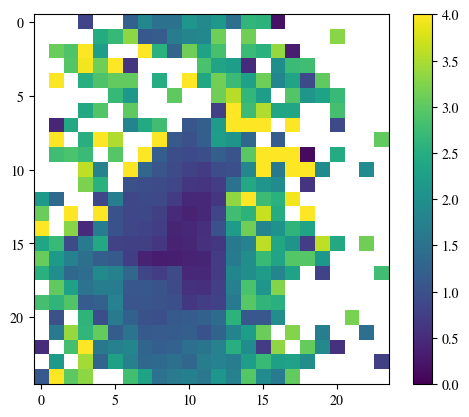

In [156]:
plt.imshow(som_data, vmin = 0, vmax=4)
plt.colorbar()

## SOM VISUAIZATION IN THE TRAINING SAMPLE

In [135]:
f, ferr, specz ,VIS_mag = photoz_archive.get_training_data()

In [136]:
bmu = selforgmap.test_obj(f)

In [137]:
df = pd.DataFrame(np.c_[specz, bmu], columns = ['zs','cell'])

In [142]:
som_vis = df.groupby('cell').zs.mean().reset_index().rename(columns = {'zs':'zs_som'})



In [143]:
x_cells = np.arange(0,nx)
y_cells = np.arange(0,ny)
index_cell = np.arange(nx*ny)
cells = np.array(np.meshgrid(x_cells,y_cells)).T.reshape(-1,2)
cells = pd.DataFrame(np.c_[cells[:,0],cells[:,1],index_cell], columns = ['x_cell','y_cell','cell'])

In [144]:
som_data = som_vis.merge(cells, on = 'cell')
som_data = som_data.pivot(index = 'x_cell', columns = 'y_cell', values = 'zs_som')

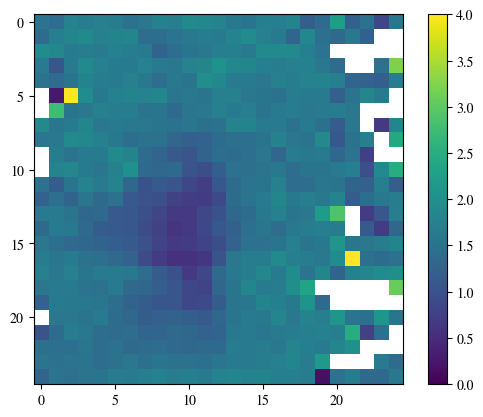

In [145]:
plt.imshow(som_data, vmin = 0, vmax=4)
plt.colorbar()

with predicted and PAUS redshifts